
# CC3084 – Data Science · Laboratorio 5: RNN (LSTM) para Series de Tiempo




In [ ]:

# Importaciones y configuración 
import os
import math
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Keras / TensorFlow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Configuración general de gráficos
plt.rcParams['figure.figsize'] = (10, 4)
plt.rcParams['axes.grid'] = True

# Reproducibilidad
SEED = 42
np.random.seed(SEED)
import tensorflow as tf
tf.random.set_seed(SEED)



## 1) Carga y exploración de datos

El siguiente bloque intenta **dos rutas**:

**A.** Descargar la serie desde FRED usando `pandas_datareader`.  
**B.** (Alternativa) Cargar un archivo CSV local (por ejemplo, `IPN31152N.csv`) con columnas `DATE` y `IPN31152N`.

> Si estás en un entorno sin Internet, utiliza la opción B y coloca el CSV en la misma carpeta de tu notebook.


In [ ]:

# Parámetros de carga 
SERIE = "IPN31152N"  

def cargar_desde_fred(serie=SERIE):
    """Intenta descargar la serie desde FRED con pandas_datareader."""
    try:
        from pandas_datareader import data as pdr
        df = pdr.DataReader(serie, 'fred')
        df = df.rename(columns={serie: 'value'})
        df = df.dropna()
        df.index = pd.to_datetime(df.index)
        df = df.asfreq('MS')  # frecuencia mensual inicio de mes
        return df
    except Exception as e:
        print(f"No fue posible descargar desde FRED: {e}")
        return None



df = cargar_desde_fred(SERIE)


if df is None or df.empty:
    raise RuntimeError("No fue posible cargar la serie. Descarga el CSV desde FRED o habilita Internet para usar pandas-datareader.")

print(df.head())
print("\nCantidad de filas:", len(df))
print("Rango de fechas:", df.index.min().date(), "→", df.index.max().date())


               value
DATE                
2020-10-01  106.2640
2020-11-01   99.5616
2020-12-01   90.4432
2021-01-01  106.0187
2021-02-01  119.2644

Cantidad de filas: 57
Rango de fechas: 2020-10-01 → 2025-06-01


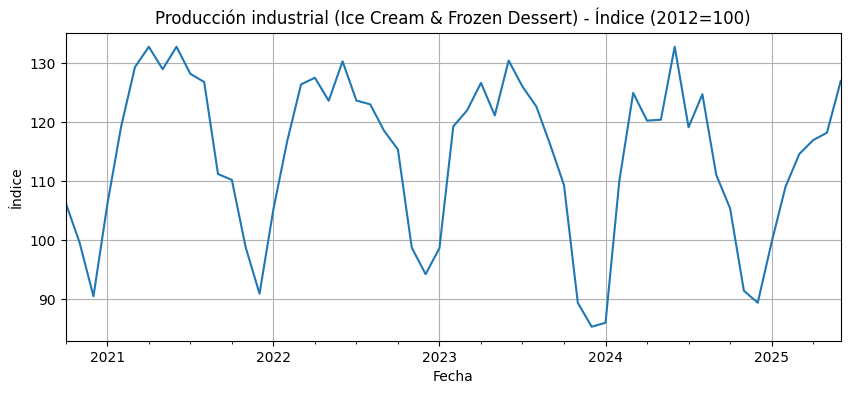

,value
count,57.000000
mean,114.091800
std,13.670936
min,85.283900
25%,105.391900
50%,118.219200
75%,124.978700
max,132.817000


In [4]:

# Exploración básica 
ax = df['value'].plot(title='Producción industrial (Ice Cream & Frozen Dessert) - Índice (2012=100)')
ax.set_xlabel('Fecha')
ax.set_ylabel('Índice')
plt.show()

# Descripción estadística
display(df.describe())



## 2) División de conjuntos (train / test)




Tamaños -> train: 33  test: 24
Rango train: 2020-10-01 → 2023-06-01
Rango test: 2023-07-01 → 2025-06-01


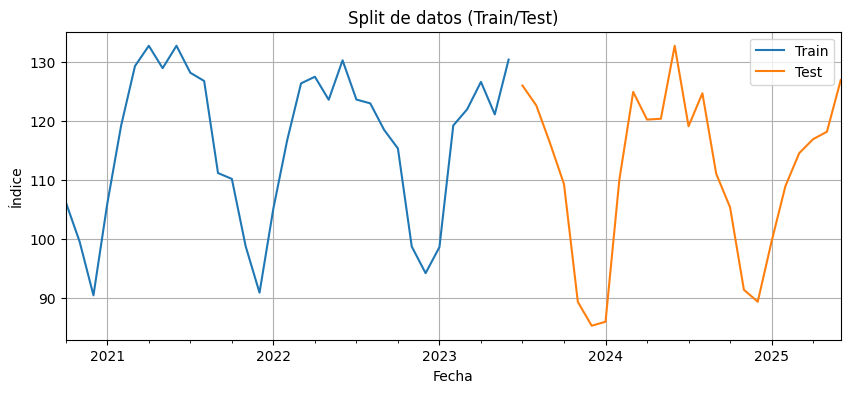

In [ ]:

# División train / test 
TEST_MESES = 24
n_total = len(df)
if n_total <= TEST_MESES + 30:
    print("Advertencia: Muy pocos datos para una división estable. Considera descargar más histórico." )

n_test = TEST_MESES
n_train = n_total - n_test

train = df.iloc[:n_train].copy()
test  = df.iloc[n_train:].copy()

print("Tamaños -> train:", len(train), " test:", len(test))
print("Rango train:", train.index.min().date(), "→", train.index.max().date())
print("Rango test:",  test.index.min().date(),  "→", test.index.max().date())

# Visual: train vs test
ax = train['value'].plot(label='Train', title='Split de datos (Train/Test)')
test['value'].plot(ax=ax, label='Test')
ax.legend()
ax.set_xlabel('Fecha')
ax.set_ylabel('Índice')
plt.show()



## 3) Normalización y preparación de secuencias

Usaremos MinMaxScaler ajustado solo con entrenamiento. Luego creamos un TimeseriesGenerator.


In [7]:

# Normalización 
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train[['value']])
train_scaled = scaler.transform(train[['value']])
test_scaled  = scaler.transform(test[['value']])

# Generador de secuencias 
WINDOW = 12      
HORIZON = 1      
BATCH_SIZE = 16

gen_train = TimeseriesGenerator(train_scaled, train_scaled, length=WINDOW, batch_size=BATCH_SIZE)
gen_test  = TimeseriesGenerator(test_scaled,  test_scaled,  length=WINDOW, batch_size=BATCH_SIZE)

print(f"Batches en train: {len(gen_train)} | Batches en test: {len(gen_test)}")


Batches en train: 2 | Batches en test: 1



## 4) Construcción del modelo LSTM



In [8]:

# Modelo LSTM 
model = Sequential([
    LSTM(64, input_shape=(WINDOW, 1)),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


C:\Users\Eduar\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)


## 5) Entrenamiento y curvas de pérdida


Epoch 1/200


C:\Users\Eduar\AppData\Roaming\Python\Python313\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - loss: 0.3112 - mae: 0.4866 - val_loss: 0.1764 - val_mae: 0.3714 - learning_rate: 0.0010
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.2346 - mae: 0.4194 - val_loss: 0.1348 - val_mae: 0.3221 - learning_rate: 0.0010
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.1791 - mae: 0.3717 - val_loss: 0.1055 - val_mae: 0.2849 - learning_rate: 0.0010
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1265 - mae: 0.3259 - val_loss: 0.0895 - val_mae: 0.2590 - learning_rate: 0.0010
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.1049 - mae: 0.2965 - val_loss: 0.0894 - val_mae: 0.2512 - learning_rate: 0.0010
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1269 - mae: 0.2973 - val_loss: 0.1030 - val_mae: 0.2541 - learning_rate: 0.0010
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.1232 - mae: 0.2755 - val_loss: 0.1155 - val_mae: 0.2619 - learning_rate: 0.0010
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━

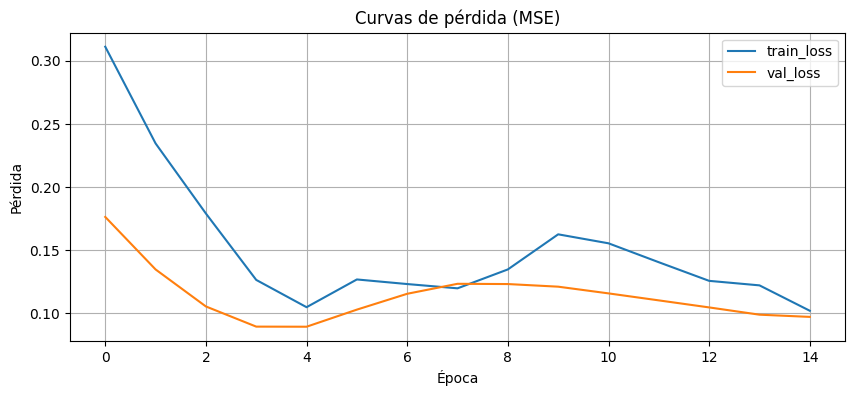

In [9]:

# Callbacks y entrenamiento 
early = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

history = model.fit(
    gen_train,
    validation_data=gen_test,
    epochs=200,
    callbacks=[early, rlr],
    verbose=1
)

# Curvas de pérdida
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Curvas de pérdida (MSE)')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()



## 6) Evaluación y predicciones (test)

Calculamos pronósticos one-step-ahead sobre el tramo de prueba, invertimos la escala y comparamos con la realidad.


MAE:  10.641
RMSE: 12.671
MAPE: 10.14%


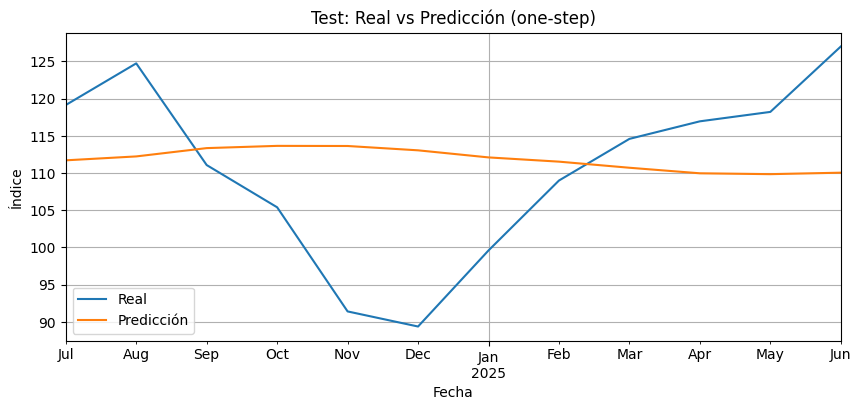

,y_true,y_pred
DATE,,
2024-07-01,119.1464,111.707756
2024-08-01,124.7476,112.233391
2024-09-01,111.0717,113.350609
2024-10-01,105.3919,113.652130
2024-11-01,91.3876,113.635048


In [10]:

# Predicciones sobre test (one-step rolling)
# Usaremos una ventana deslizante sobre test_scaled
pred_scaled = []
for i in range(len(test_scaled) - WINDOW):
    x = test_scaled[i:i+WINDOW]
    x = x.reshape((1, WINDOW, 1))
    yhat = model.predict(x, verbose=0)
    pred_scaled.append(yhat[0,0])

# Alinear con los valores reales correspondientes 
pred_scaled = np.array(pred_scaled).reshape(-1, 1)
pred = scaler.inverse_transform(pred_scaled).flatten()

y_true_scaled = test_scaled[WINDOW:]
y_true = scaler.inverse_transform(y_true_scaled).flatten()

# Métricas
mae = mean_absolute_error(y_true, pred)
rmse = math.sqrt(mean_squared_error(y_true, pred))
mape = np.mean(np.abs((y_true - pred) / y_true)) * 100

print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.2f}%")

# Serie para graficar
fechas_pred = test.index[WINDOW:]
df_eval = pd.DataFrame({
    'y_true': y_true,
    'y_pred': pred
}, index=fechas_pred)

# Gráfica comparación real vs predicción 
ax = df_eval['y_true'].plot(label='Real', title='Test: Real vs Predicción (one-step)')
df_eval['y_pred'].plot(ax=ax, label='Predicción')
ax.set_xlabel('Fecha')
ax.set_ylabel('Índice')
ax.legend()
plt.show()

df_eval.head()



### Pronóstico de los próximos k meses

Usando el último tramo de datos, generamos un pronóstico iterativo.


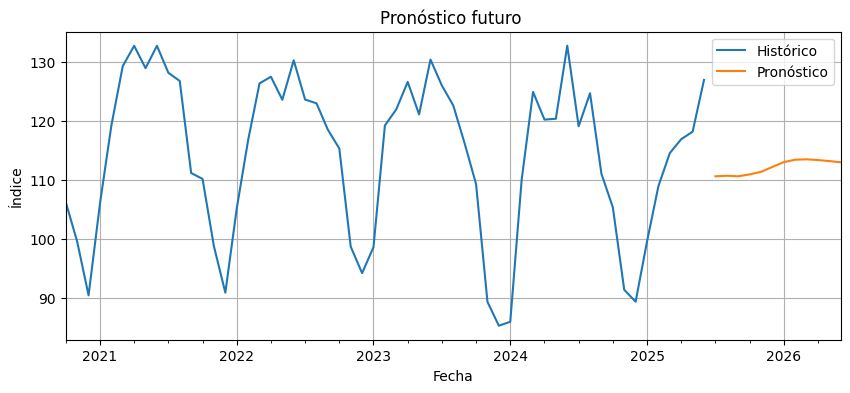

,forecast
2025-07-01,110.651245
2025-08-01,110.740974
2025-09-01,110.651611
2025-10-01,110.969414
2025-11-01,111.405373


In [12]:

# Pronóstico multi-paso 
K = 12  # meses a pronosticar
hist_window = df[['value']].copy()
hist_scaled = scaler.transform(hist_window)

window = hist_scaled[-WINDOW:].reshape(1, WINDOW, 1).copy()

future_scaled = []
for _ in range(K):
    yhat = model.predict(window, verbose=0)[0,0]
    future_scaled.append(yhat)
    window = np.concatenate([window[:,1:,:], yhat.reshape(1,1,1)], axis=1)

future = scaler.inverse_transform(np.array(future_scaled).reshape(-1,1)).flatten()

# Índice de fechas futuras
last_date = df.index.max()
future_index = pd.date_range(last_date + pd.offsets.MonthBegin(1), periods=K, freq='MS')

df_future = pd.DataFrame({'forecast': future}, index=future_index)

# Visualizar histórico + forecast
ax = df['value'].plot(label='Histórico', title='Pronóstico futuro ')
df_future['forecast'].plot(ax=ax, label='Pronóstico')
ax.set_xlabel('Fecha')
ax.set_ylabel('Índice')
ax.legend()
plt.show()

df_future.head()



## 7) Discusión 

> - ¿La LSTM capturó estacionalidad y tendencia?  
> - ¿Qué tan buenas/bajas son las métricas (MAE/RMSE/MAPE) para tu contexto?  
> - ¿Sobre/infra-ajuste? ¿Cómo lo detectaste (curvas de pérdida)?  
> - ¿Qué mejoras harías (tamaño de ventana, más capas, otras regularizaciones, tuning de LR, diferenciar/estandarizar, etc.)?  
> - ¿Compararías con un modelo base (naive, moving average) o con ARIMA/Prophet para tener referencia?


Link de Github:
https://github.com/Riv2oo4/Lab5_DS.git
